In [1]:
from keras.applications import VGG16

Using TensorFlow backend.


In [2]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3))

In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [5]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [6]:
# base_dir = 'G:/KerasLearning/data/dogs-vs-cats'
base_dir = '/home/james/Program/KerasLearning/data/dogs-vs-cats'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [7]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [9]:
from keras import models, layers, optimizers

In [10]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(train_features, train_labels,
          epochs=30,
          batch_size=20,
          validation_data=(validation_features, validation_labels))


Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 616us/step - loss: 0.6979 - acc: 0.5755 - val_loss: 0.5530 - val_acc: 0.7430
Epoch 2/30
2000/2000 [==============================] - 0s 211us/step - loss: 0.5446 - acc: 0.7195 - val_loss: 0.4468 - val_acc: 0.8440
Epoch 3/30
2000/2000 [==============================] - 0s 207us/step - loss: 0.4521 - acc: 0.7850 - val_loss: 0.3912 - val_acc: 0.8600
Epoch 4/30
2000/2000 [==============================] - 0s 212us/step - loss: 0.3890 - acc: 0.8375 - val_loss: 0.3589 - val_acc: 0.8600
Epoch 5/30
2000/2000 [==============================] - 0s 215us/step - loss: 0.3545 - acc: 0.8505 - val_loss: 0.3335 - val_acc: 0.8710
Epoch 6/30
2000/2000 [==============================] - 0s 209us/step - loss: 0.3386 - acc: 0.8560 - val_loss: 0.3168 - val_acc: 0.8790
Epoch 7/30
2000/2000 [==============================] - 0s 220us/step - loss: 0.3164 - acc: 0.8720 - val_loss: 0.3016 - val_acc: 0.8860


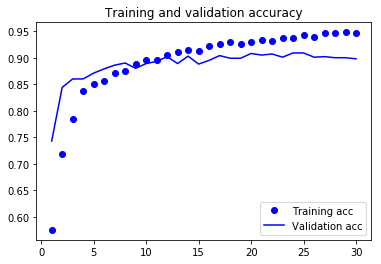

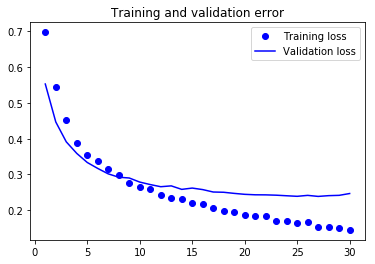

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt

%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation error')
plt.legend()

plt.figure()

plt.show()

In [12]:
#Method 2 need GPU
from keras import layers, models

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [16]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [17]:
conv_base.trainable = False

In [18]:
print('This is the number of trainable weights'
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weightsafter freezing the conv base: 4


In [19]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
test_datagen =  ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.


In [23]:
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')

Found 1000 images belonging to 2 classes.


In [25]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [26]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 17s 168ms/step - loss: 0.5953 - acc: 0.6860 - val_loss: 0.4532 - val_acc: 0.8210
Epoch 2/30
100/100 [==============================] - 15s 152ms/step - loss: 0.4840 - acc: 0.7780 - val_loss: 0.3685 - val_acc: 0.8550
Epoch 3/30
100/100 [==============================] - 15s 152ms/step - loss: 0.4326 - acc: 0.8145 - val_loss: 0.3311 - val_acc: 0.8640
Epoch 4/30
100/100 [==============================] - 15s 152ms/step - loss: 0.4041 - acc: 0.8235 - val_loss: 0.3074 - val_acc: 0.8710
Epoch 5/30
100/100 [==============================] - 15s 151ms/step - loss: 0.3824 - acc: 0.8245 - val_loss: 0.2904 - val_acc: 0.8780
Epoch 6/30
100/100 [==============================] - 15s 151ms/step - loss: 0.3740 - acc: 0.8370 - val_loss: 0.2798 - val_acc: 0.8800
Epoch 7/30
100/100 [==============================] - 15s 152ms/step - loss: 0.3558 - acc: 0.8400 - val_loss: 0.2714 - val_acc: 0.8880
Epoch 8/30
100/100 [==============================] - 1

<Figure size 432x288 with 0 Axes>

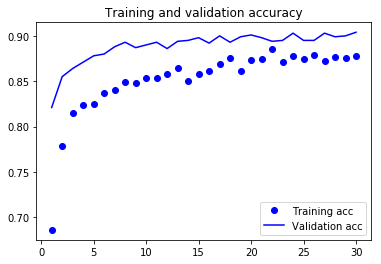

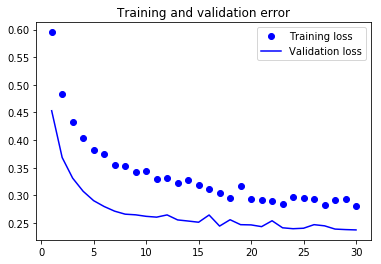

<Figure size 432x288 with 0 Axes>

In [28]:
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation error')
plt.legend()

plt.figure()
